In [ ]:
!pip install numpy==1.25.2
!pip install matplotlib=3.7.1
!pip install networkx==3.1
!pip install scipy==1.11.1
!pip install sympy==1.11.1

In [2]:
import numpy as np

import math

import copy
import random
import pickle

import datetime

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.integrate as integrate
from scipy.optimize import minimize

import sympy as sp

import gc


In [3]:
t,k,d,T1=sp.symbols('t,k,d,T1')

T=sp.Symbol('T', positive=True)

In [4]:
def fhat(t,k,d,T):
    return (t**(k-1)*sp.exp(-t)/sp.factorial(k-1))*sp.exp(-(T-t)*(d-1))

fhat(t,k,d,T)

t**(k - 1)*exp(-t)*exp((-T + t)*(d - 1))/factorial(k - 1)

Given the source $v_j$ (i.e., the tree root of $G_N$) and a time $T$, the probability of node $v_i$ being the leaf of $G_N$ and all its susceptible children $v_l\in \mathcal{B}(G_N)$ (rumor graph boundary of $G_N$) is given by
$$
\underbrace{P\left(v_i\displaystyle\bigcap_{v_l\in\textrm{child}(v_i)}^L {\bar{v}}_l\,\bigg|\,v_j,T\right)}_{:=P'} = \int_0^T \frac{t^{K_{ij}-1}e^{-t}}{(K_{ij}-1)!}e^{-(T-t)(d_i-1)} \mathrm{d}t.
$$

In [5]:
sp.Integral(fhat(t,k,d,T),(t, 0, T))

Integral(t**(k - 1)*exp(-t)*exp((-T + t)*(d - 1))/factorial(k - 1), (t, 0, T))

In [6]:
def g(k,d,T):
    return sp.integrate(fhat(t,k,d,T),(t, 0, T))

def h(G, leaf_infected, s, u, T):
    if s==u:
        return 1
    else:
        k=nx.shortest_path_length(G, s, u)
        d= G.degree[u] if u in leaf_infected else 2
        return g(k,d, T)

# P(G_N|s, T)
def p(G, nodes_infected, leaf_infected,pseudo_leaf_infected, s, T):
    prod=1
    for u in leaf_infected:
        if u!=s:
            prod=prod*h(G=G,leaf_infected=leaf_infected,s=s, u=u, T=T)
    for u in pseudo_leaf_infected:
        if u!=s:
            prod=prod*h(G=G,leaf_infected=leaf_infected,s=s, u=u, T=T)
    for u in set(G[s]).difference(nodes_infected):
        prod=prod*sp.exp(-T)
    return prod

## Properties of P'

$P'$ against $K_{ij}$, the depth of node $i$ when $j$ is the source.

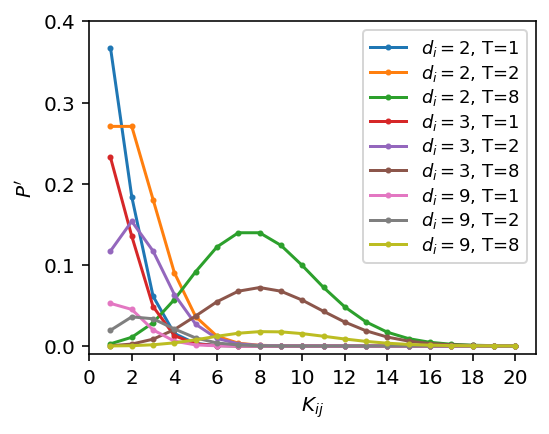

In [7]:
kmax=21
dmax=21
Tmax=21

k_lst=[1,2,8]
d_lst=[2,3,9]
T_lst=[1,2,8]

fig, ax = plt.subplots(figsize=(4,3),dpi=144)

xrange = range(1, kmax)
for dd in d_lst:
    for TT in T_lst:
        yy = [g(xx,dd,TT) for xx in xrange]
        ax.plot(xrange, yy, 'o-', markersize=2, label = r'$d_i=$'+str(dd)+', T='+str(TT))
ax.legend(labelspacing = 0.2, fontsize='9')
ax.set_xlabel(r'$K_{ij}$')
ax.set_ylabel(r"$P'$")
plt.xticks(np.arange(0,kmax,2))
plt.ylim(-0.01,0.4)

# ax.grid()

plt.show()

$P'$ against $d_i$, the degree of node $i$.

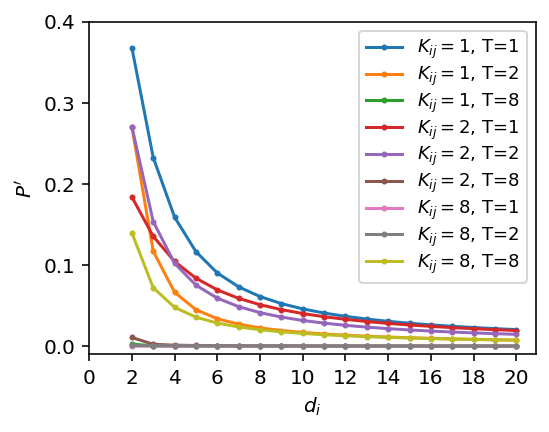

In [8]:
kmax=21
dmax=21
Tmax=21

k_lst=[1,2,8]
d_lst=[2,3,9]
T_lst=[1,2,8]

fig, ax = plt.subplots(figsize=(4,3),dpi=144)

xrange = range(2, kmax)
for kk in k_lst:
    for TT in T_lst:
        yy = [g(kk,xx,TT) for xx in xrange]
        ax.plot(xrange, yy, 'o-', markersize=2, label = r'$K_{ij}=$'+str(kk)+', T='+str(TT))
ax.legend(labelspacing = 0.2, fontsize='9')
ax.set_xlabel(r'$d_i$')
ax.set_ylabel(r"$P'$")
plt.xticks(np.arange(0,kmax,2))
plt.ylim(-0.01,0.4)

# ax.grid()

plt.show()

$P'$ against time $T$.

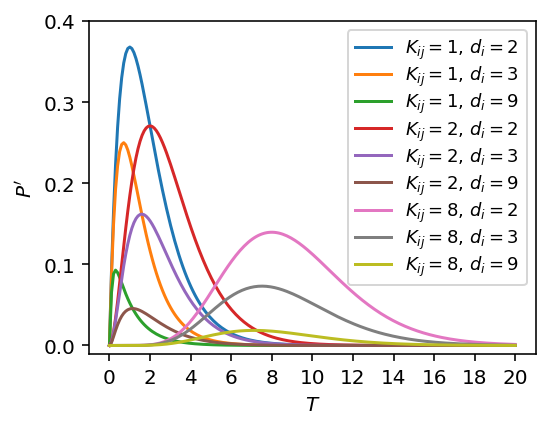

In [9]:
# kmax, dmax, Tmax are used for setting the range
kmax=21
dmax=21
Tmax=20

k_lst=[1,2,8]
# d_lst=[1,2,8]
d_lst=[2,3,9]
T_lst=[1,2,8]

fig, ax = plt.subplots(figsize=(4,3),dpi=144)

xrange = np.linspace(0, Tmax, 200)
for kk in k_lst:
    for dd in d_lst:
        yy = [g(kk,dd,xx) for xx in xrange]
        ax.plot(xrange, yy, label = r'$K_{ij}=$'+str(kk)+', '+r'$d_i=$'+str(dd))
ax.legend(labelspacing = 0.16, fontsize='9')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r"$P'$")
plt.xticks(np.arange(0,kmax,2))
plt.ylim(-0.01,0.4)

# ax.grid()

plt.show()

---

## The grid graph for showing how Algorithm 2 in the paper works.

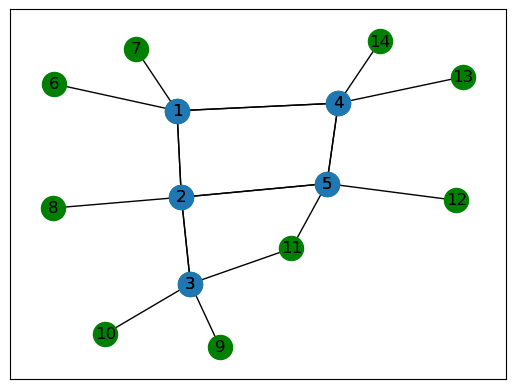

In [10]:
G=nx.Graph()
# pay attention to the order of the nodes added, otherwise nx.bfs_tree will not be in the numerical order
G.add_edges_from([(1,2),(1,4),(2,3),(2,5),(4,5),(1,6),(1,7),(2,8)])
G.add_edges_from([(3,9),(3,10),(3,11),(5,11),(5,12),(4,13),(4,14)])
pos=nx.spring_layout(G, iterations=500, seed=13)

nodes_infected={1,2,3,4,5}

nx.draw_networkx(G, pos=pos, node_color='green', with_labels=True)
nx.draw_networkx(G.subgraph(nodes_infected), pos=pos, with_labels=True)

In [11]:
nodes_infected={1,2,3,4,5}
group_G={}
for j in nodes_infected:
    group_G[j]=nx.Graph(G)

In [12]:
# define the function for find the bfs tree w.r.t. to the source
def manual_bfs_tree(G,source):
    tree=nx.DiGraph()
    tree.add_node(source)
    temp_all_nodes = set(G.nodes()) - {source}
    while len(temp_all_nodes)!=0:
        cand=nx.node_boundary(G, tree.nodes())
        temp_all_nodes -= cand
        boundary_of_tree = sorted(nx.node_boundary(G, cand, tree.nodes()))

        for v in boundary_of_tree:
            v_accrossing = list(nx.edge_boundary(G, {v}, cand))
            tree.add_edges_from(v_accrossing)
            for e in v_accrossing:
                cand.remove(e[1]) 
    return tree

In [13]:
# define the function for generating the bfs tree that corresponds to the rumor graph
def extract_bfs(gr_main, gr_nodes_infected, gr_nodes_susceptible, s_selected):
    gr_bfs=manual_bfs_tree(gr_main.subgraph(gr_nodes_infected), s_selected).to_undirected()
    for i in gr_nodes_susceptible:
        if gr_main.degree[i]==1:
            gr_bfs.add_edges_from(gr_main.edges(i))
        else:
            v_cand=sorted([v for (_,v) in gr_main.edges(i)],reverse=True)
            # print(gr_main.edges(i),v_cand)
            v_dist_min=np.inf
            v_arg_min=v_cand[0]  # the infected neighbors of i that will be selected by bfs w.r.t s_selected
            for v in v_cand:
                v_dist=nx.shortest_path_length(gr_bfs, s_selected, v)
                if v_dist<=v_dist_min:
                    v_arg_min=v
                    v_dist_min=v_dist
            gr_bfs.add_edge(i, v_arg_min)
    return gr_bfs

In [14]:
group_G={}
for j in nodes_infected:
    group_G[j]=extract_bfs(gr_main=G, gr_nodes_infected=nodes_infected, gr_nodes_susceptible=nx.node_boundary(G,nodes_infected), s_selected=j)


An example for the BFS tree for the rumor spreading when node $i=3$ is the source. 

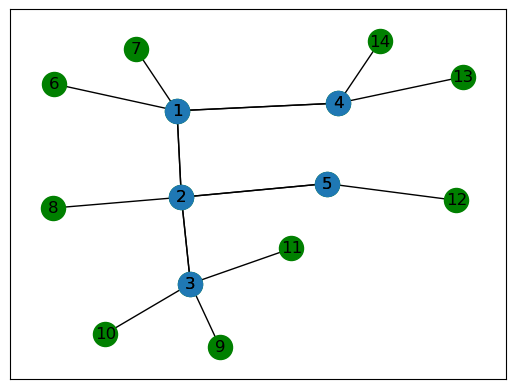

In [15]:
i=3
nx.draw_networkx(group_G[i], pos=pos, node_color='green', with_labels=True)
nx.draw_networkx(group_G[i].subgraph(nodes_infected), pos=pos, with_labels=True)

In [16]:
# find the set of leaf infected nodes and the set of pseudo leaf infected nodes
for j in nodes_infected:
    leaf_infected=set()
    pseudo_leaf_infected=set()
    for i in nodes_infected:
        if len(list(group_G[j].subgraph(nodes_infected)[i]))==1:
            leaf_infected.add(i)
        elif len(list(group_G[j].subgraph(nodes_infected)[i]))!=len(list(group_G[j])):
            pseudo_leaf_infected.add(i)
            
    # print(leaf_infected,pseudo_leaf_infected)    

<Figure size 400x250 with 0 Axes>

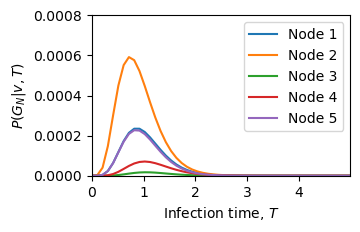

In [17]:
Tmax=5
xvalues = np.linspace(0, Tmax, max(50, 5*Tmax))
q={}
plt.figure(figsize=(4, 2.5))
plt.figure(figsize=(4/1.2, 2.5/1.2))
for u in nodes_infected:
    if u in nodes_infected:
        q[u]=p(group_G[u],nodes_infected, leaf_infected, pseudo_leaf_infected, s=u, T=T).subs({T:T})
        yvalues = [q[u].subs({T:x}) for x in xvalues]
        plt.plot(xvalues, yvalues, label='Node '+str(u))
# plt.legend()
plt.xlabel('Infection time, '+r'$T$')
plt.ylabel(r'$P(G_N|v,T)$')
plt.xlim(0,Tmax)
# plt.ylim(0, 0.3)
# plt.ylim(0, 0.04)
plt.ylim(0, 0.0008)
plt.xticks(np.arange(0,Tmax,1))
# plt.xticks(np.arange(0,Tmax,2))
plt.legend()
# plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

The closed form for $P(G_N|3,T)$:

In [18]:
sp.simplify(q[3])

T**3*((2*T - 1)*exp(2*T) + 1)*((T**2 - 2*T + 2)*exp(T) - 2)*exp(-10*T)/16

---

## Line graphs, Star(like) graphs

### only choose one of the types of graph to generate

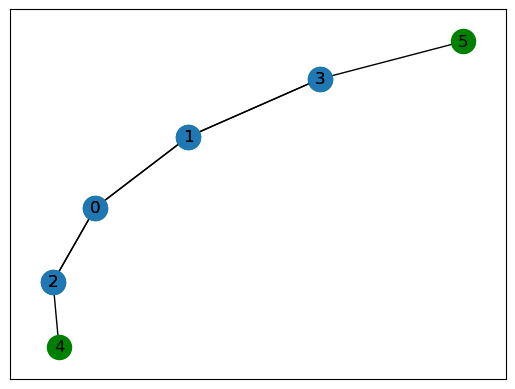

In [19]:
# line graph with no leaf infected node
n=4
G=nx.Graph()
nodes_infected=set()
G.add_node(0)
nodes_infected.add(0)
for i in range(1,n):
    if i==0 or i==1:
        G.add_edge(0,i)
    else:
        G.add_edge(i-2,i)
    nodes_infected.add(i)
G.add_edges_from([(n-2,n),(n-1,n+1)])

pos=nx.spring_layout(G, seed=0)
nx.draw_networkx(G, pos=pos, node_color='green', with_labels=True)
nx.draw_networkx(G.subgraph(nodes_infected), pos=pos, with_labels=True)

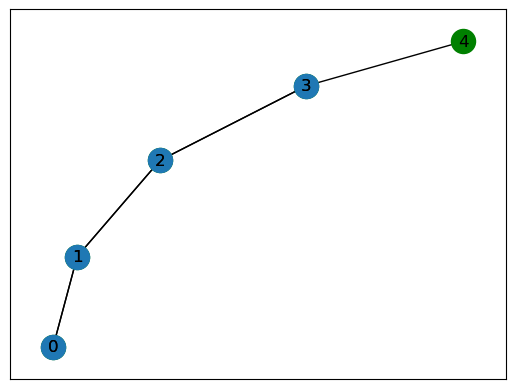

In [20]:
# line graph with 0 being a leaf infected node
n=4
G=nx.path_graph(n)
nodes_infected=set(G.nodes())
G.add_edge(n-1,n)

pos=nx.spring_layout(G, seed=0)
nx.draw_networkx(G, pos=pos, node_color='green', with_labels=True)
nx.draw_networkx(G.subgraph(nodes_infected), pos=pos, with_labels=True)

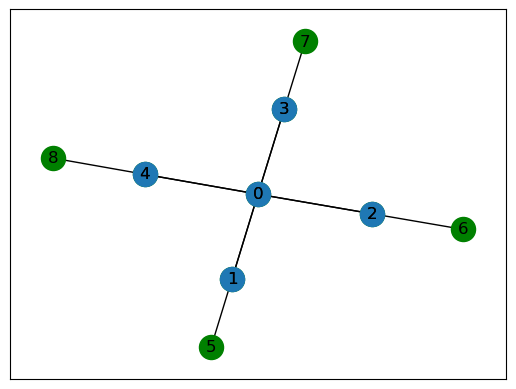

In [21]:
# star gaph
n=5
G=nx.Graph()
G.add_node(0)
nodes_infected={0}
for i in range(1,n):
    G.add_edge(0,i)
    nodes_infected.add(i)
    G.add_edge(i,n-1+i)

pos=nx.spring_layout(G, seed=0)
nx.draw_networkx(G, pos=pos, node_color='green', with_labels=True)
nx.draw_networkx(G.subgraph(nodes_infected), pos=pos, with_labels=True)

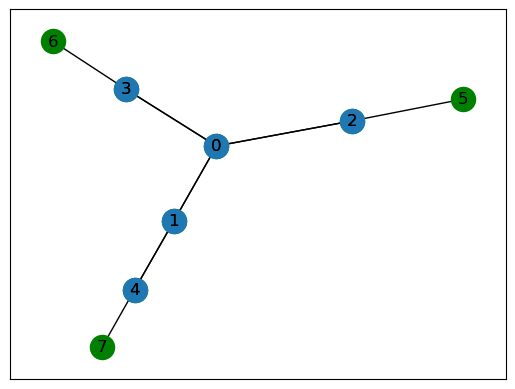

In [22]:
# starlike gaph
# n_branch=3
# i_branch=[4,1,1,1] # number of infected nodes in each branch, each element corresponds to a branch
# u_branch=[0,1,1,1] # whether there is susceptible node in the branch
i_branch=[2,1,1] # number of infected nodes in each branch, each element corresponds to a branch
u_branch=[1,1,1] # whether there is susceptible node in each branch
# n=sum(i_branch)
i_branch_last=[0]* len(i_branch) # the last node in each branch
G=nx.Graph()
G.add_node(0)
nodes_infected={0}
for j in range(0, max(i_branch)+1):
    for i in range(0,len(i_branch)):
        if i_branch[i]>0:
            new_node=len(G)
            G.add_edge(i_branch_last[i],new_node)
            i_branch_last[i]=new_node
            i_branch[i]-=1
            nodes_infected.add(new_node)
        elif i_branch[i]==0 and u_branch[i]!=0:
            G.add_edge(i_branch_last[i],len(G))
            i_branch[i]-=1
        else:
            pass

pos=nx.spring_layout(G, seed=0)
nx.draw_networkx(G, pos=pos, node_color='green', with_labels=True)
nx.draw_networkx(G.subgraph(nodes_infected), pos=pos, with_labels=True)

### Compute the (pseudo)leaf infected nodes and plot the rumor graph.

In [23]:
pos_SEED=0
pos=nx.spring_layout(G, seed=pos_SEED)

leaf_infected=set()
pseudo_leaf_infected=set()
for i in nodes_infected:
    if len(list(G.subgraph(nodes_infected)[i]))==1:
        leaf_infected.add(i)
    elif len(list(G.subgraph(nodes_infected)[i]))!=len(list(G[i])):
        pseudo_leaf_infected.add(i)

print(leaf_infected,pseudo_leaf_infected)

{2, 3, 4} set()


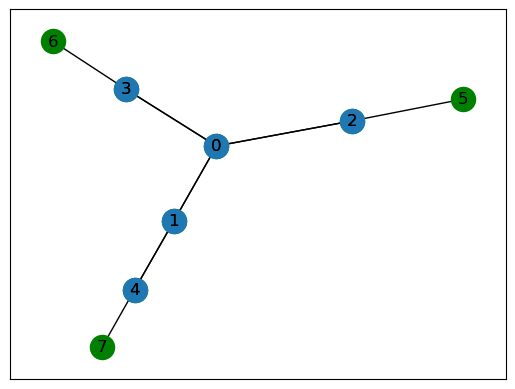

In [24]:
nx.draw_networkx(G, pos=pos, node_color='green', with_labels=True)
nx.draw_networkx(G.subgraph(nodes_infected), pos=pos, with_labels=True)

<Figure size 400x250 with 0 Axes>

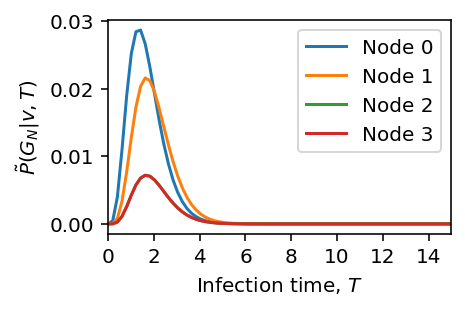

In [25]:
Tmax=15
xvalues = np.linspace(0, Tmax, 5*Tmax)
q={}
plt.figure(figsize=(4,2.5))
# plt.figure(figsize=(4,2.5),dpi=144)
plt.figure(figsize=(4/1.3,2.5/1.3),dpi=144)
for u in nodes_infected:
    if u in {0,1,2,3}:
    # if u in {0,1,2,4,7,8}:
        q[u]=p(G,nodes_infected, leaf_infected, pseudo_leaf_infected, s=u, T=T).subs({T:T})
        yvalues = [q[u].subs({T:x}) for x in xvalues]
        plt.plot(xvalues, yvalues, label='Node '+str(u))
# plt.legend()
plt.xlabel('Infection time, '+r'$T$')
plt.ylabel(r'$\tilde{P}(G_N|v,T)$')
plt.xlim(0,Tmax)
# plt.ylim(0, 0.3)
# plt.ylim(0, 0.04)
# plt.ylim(0, 0.06)
# plt.ylim(0, 0.02)
plt.xticks(np.arange(0,Tmax,2))
plt.legend()
# plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.) 

Compute the time when a node $u$ achieves maximum $P'$.

In [26]:
u = 0
lam_neg_qu = sp.lambdify(T,-q[u])
sol_neg_qu = minimize(lam_neg_qu, 1, bounds=[[0,np.inf]])
argmax_t = sol_neg_qu.x
max_P = - sol_neg_qu.fun

print("At time ", argmax_t,  ", P' achieves maximum value ", max_P)

At time  [1.33333201] , P' achieves maximum value  0.028943231824115425


---

## Asymptotics in Performance of Likelihood Estimation

### Star graph

The ratio of the likelihood probability between the non-central node and the central node in star graphs with different number of infected nodes.

In star graph,
consider the ratio 
$$\frac{\max_{t} \ P(G_N|1, t)}{\max_{t} \ P(G_N|0, t)}$$
where the central node $0$ as the souce, and node other nodes are infected in the order of their label, i.e., node $1$ are infected, then node $2$, $3$ $\dots$.


`asy_n_list` is the list of the number of infected nodes in the star graphs we want to test.

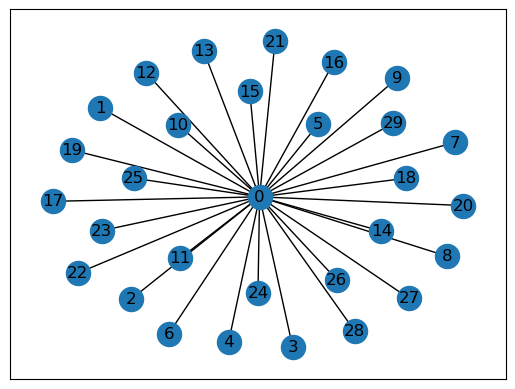

In [27]:
# star graph
n_total = 30
n_infected_total = n_total
G=nx.Graph()
G.add_node(0)
for i in range(1,n_total):
    G.add_edge(0, i)
    
nx.draw_networkx(G)

asy_ratio = {}

asy_n_list = list(range(5, n_infected_total+1, 5))


In [28]:
# find the t that maximized the sympy function p
def find_max_p_over_t(p, t_left=0, t_right=10**6, epsilon=10**-3):
    # p is a sympy function of variable T
    t_left += 10**-3
    p_left = p.subs({T:t_left})
    p_right = p.subs({T:t_right})
    pdiff = sp.diff(p, T)
    pdiff_left = pdiff.subs({T:t_left})
    pdiff_right = pdiff.subs({T:t_right})
    # print('pdiff_right', pdiff_right, pdiff_right>0)
    if pdiff_right > 0:
        if 1-p_right<10**-6:
            p_right=1
        return t_right, p_right
    else:
        while t_right-t_left>epsilon:
            t_mid = (t_left + t_right) /2
            pdiff_mid = pdiff.subs({T:t_mid})
            if pdiff_mid>0:
                t_left=t_mid
                pdiff_left=pdiff_mid
            else:
                t_right=t_mid
                pdiff_right = pdiff_mid
        # print(t_mid, p.subs({T:t_mid}))
        return t_mid, p.subs({T:t_mid})


In [29]:

for n_infected in asy_n_list:
    nodes_infected = list(range(0, n_infected))
    
    leaf_infected=set()
    pseudo_leaf_infected=set()
    for i in nodes_infected:
        if len(list(G.subgraph(nodes_infected)[i]))==1:
            leaf_infected.add(i)
        elif len(list(G.subgraph(nodes_infected)[i]))!=len(list(G[i])):
            pseudo_leaf_infected.add(i)

    q={}
    qmax={}
    for u in nodes_infected:
        if u in {0,1}:
            q[u]=p(G,nodes_infected, leaf_infected, pseudo_leaf_infected, s=u, T=T).subs({T:T})
            # lam_neg_qu = sp.lambdify(T,-q[u])
            # sol_neg_qu = minimize(lam_neg_qu, 1, method='L-BFGS-B', bounds=[[0,np.inf]])
            # qmax[u] = - sol_neg_qu.fun
            # print(sol_neg_qu.x, sol_neg_qu.fun)
            qmax[u]=find_max_p_over_t(q[u])[1]
            # print('u', u, qmax[u]) 
    # print(qmax[0],qmax[1])

    asy_ratio[n_infected] = qmax[1]/qmax[0]
    
asy_ratio_list = [asy_ratio[v] for v in asy_n_list]


In [30]:
# asy_ratio_list

Plot $\frac{\max_{t} \ P(G_N|1, t)}{\max_{t} \ P(G_N|0, t)}$ against the number of infected nodes

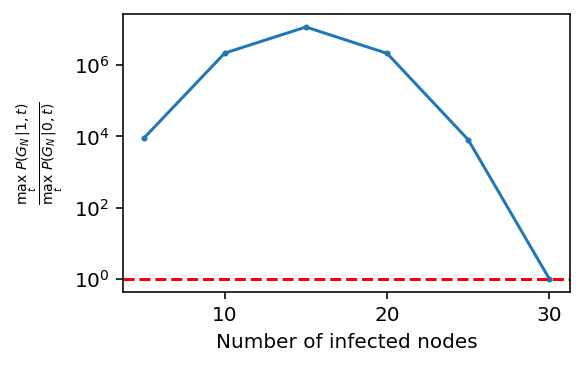

In [31]:
plt.figure(figsize=(4,2.5), dpi=144)

plt.plot(asy_n_list, asy_ratio_list, 'o-', markersize=2)

plt.xlabel('Number of infected nodes')

plt.ylabel(r'$\frac{\max_{t} \ P(G_N|1, t)}{\max_{t} \ P(G_N|0, t)}$')

# plt.ylabel(r'$\frac{P(G_N|1, t)}{P(G_N|0, t)}$')
# plt.title('observation time: '+str(observ_time),y=0.85)

plt.axhline(y = 1, color = 'r', linestyle = '--') 

ax=plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_yscale('log')
ax.set_yticks([10**0,10**2,10**4,10**6])


# ax.text(2, 0.7, '1', color='r')

Define the function for simulation.

In [32]:
# the function for simulating the infection process
def continuous_time_simulation(gnp, final_t=np.inf, t_unit=0.01,s_real=None, final_infected_num=None):
    # print("continuous_time_simulation called")

    t_unit=0.1

    t=0

    gnp=nx.Graph(gnp)

    # print(list(gnp.nodes()))


    for e in gnp.edges():
        gnp.edges[*e]["spreading_time"]=np.inf

    for n in gnp.nodes():
        gnp.nodes[n]["when_infected"]=np.inf

    if s_real==None:
        s_real=random.choice(list(gnp.nodes()))


    if final_infected_num==None:
        final_infected_num=len(nx.node_connected_component(gnp, s_real))

    gnp_pass=True
    if final_infected_num>len(nx.node_connected_component(gnp, s_real)):
        gnp_pass=False
        gr_infection_order_list=[]
        gr_infection_time_list=[]
    else:

        gnp.nodes[s_real]["when_infected"]=0

        gr_nodes_infected=set()
        gr_nodes_susceptible=set()

        gr_nodes_infected.add(s_real)

        for v in gnp.adj[s_real]:
            gr_nodes_susceptible.add(v)
            gnp[s_real][v]["spreading_time"]=max(np.random.exponential(), t_unit)
            gnp.nodes[v]["when_infected"]=gnp[s_real][v]["spreading_time"]


        while len(gr_nodes_infected)<final_infected_num and t<final_t:
            # print(len(gr_nodes_infected), final_infected_num, t)
            t+=t_unit
            for u in gr_nodes_susceptible.copy():
                if gnp.nodes[u]["when_infected"]<=t:
                    gr_nodes_infected.add(u)
                    gr_nodes_susceptible.remove(u)
                    for v in gnp.adj[u]:
                        if gnp.nodes[v]["when_infected"]==np.inf:
                            gnp[u][v]["spreading_time"]=max(np.random.exponential(), t_unit)
                            gnp.nodes[v]["when_infected"]=min(gnp.nodes[v]["when_infected"], gnp.nodes[u]["when_infected"]+gnp[u][v]["spreading_time"])         
                            gr_nodes_susceptible.add(v)

        gr_infection_order_list=[]
        gr_infection_time_list=[]

        for k, v in sorted(dict(gnp.subgraph(gr_nodes_infected).nodes(data="when_infected")).items(), key=lambda item: item[1]):
            gr_infection_order_list.append(k)
            gr_infection_time_list.append(v)

    # print("continuous_time_simulation finished")
    
    return gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list

Simlulating the infection process. `gr_infection_order_list` is the order of the nodes infected, and `gr_infection_time_list` is the infection time the corresponds to `gr_infection_order_list`. 

Notice that here we only want to get `gr_infection_order_list` since we assumed the nodes are infected according to the order of their label.

In [33]:
gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list = continuous_time_simulation(gnp=G, final_t=np.inf, t_unit=0.001,s_real=0, final_infected_num=None)

Spreading time `asy_time_list` that corresponding to `asy_n_list`

In [34]:
asy_time_list = [gr_infection_time_list[i-1] for i in asy_n_list]

In [35]:
# asy_time_list

Plot $\frac{\max_{t} \ P(G_N|1, t)}{\max_{t} \ P(G_N|0, t)}$ vs spreading time.

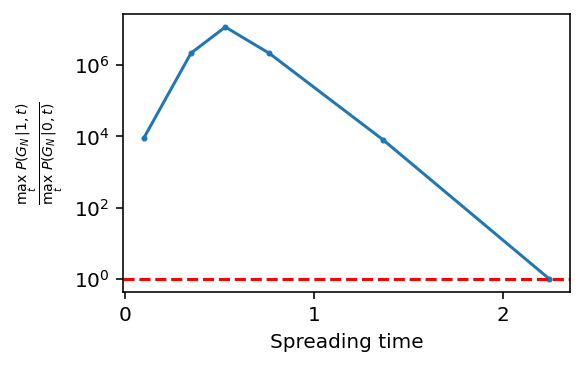

In [36]:
plt.figure(figsize=(4,2.5), dpi=144)

plt.plot(asy_time_list, asy_ratio_list,'o-', markersize=2)

plt.xlabel('Spreading time')

plt.ylabel(r'$\frac{\max_{t} \ P(G_N|1, t)}{\max_{t} \ P(G_N|0, t)}$')

# plt.ylabel(r'$\frac{P(G_N|1, t)}{P(G_N|0, t)}$')
# plt.title('observation time: '+str(observ_time),y=0.85)

plt.axhline(y = 1, color = 'r', linestyle = '--') 

ax=plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_yscale('log')
ax.set_yticks([10**0,10**2,10**4,10**6])
# ax.text(-0.4, 0.7, '1', color='r')


### Degree regular tree

In [37]:
# generate a tree with each node has degree n_deg, except the last several nodes added
def generate_degree_regular(n_total, n_deg=3):
    n_deg = 3
    G = nx.Graph()
    G.add_node(0)
    nodes_to_expand = {0}
    current_node = 0
    while current_node + 1 < n_total: 
        temp_nodes_to_expand = set()
        for j in nodes_to_expand:
            for k in range(1, n_deg) if j!=0 else range(1,n_deg+1):
                if len(G)<n_total:
                    G.add_edge(j, current_node+1)
                    current_node+=1
                    temp_nodes_to_expand.add(current_node)
                else:
                    return G
        nodes_to_expand = temp_nodes_to_expand.copy()
    return G

An example of the degree regular graph

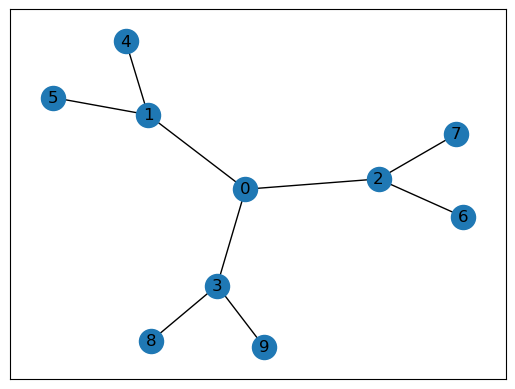

In [38]:
G=generate_degree_regular(n_total = 10)
nx.draw_networkx(G)

Generate the degree regular tree and simulate the infection process. 

`gr_infection_order_list` is the order of the nodes infected, and `gr_infection_time_list` is the infection time the corresponds to `gr_infection_order_list`. 

In [39]:
n_total = 30
G=generate_degree_regular(n_total = n_total)

gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list = continuous_time_simulation(gnp=G, final_t=np.inf, t_unit=0.001,s_real=0, final_infected_num=None)


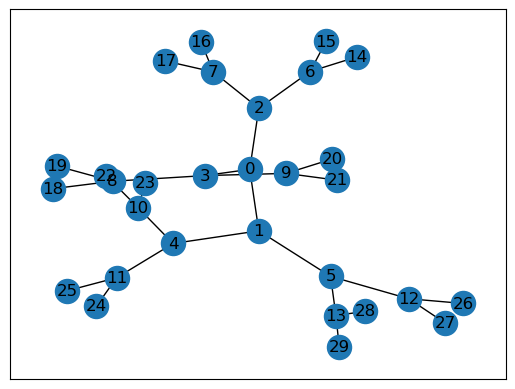

In [40]:
nx.draw_networkx(G)

In [41]:
# gr_infection_order_list


In [42]:
asy_ratio = {}

asy_n_list = list(range(5, n_total+1, 5))

for n_infected in asy_n_list:
    nodes_infected = gr_infection_order_list[0:n_infected]
    
    leaf_infected=set()
    pseudo_leaf_infected=set()
    for i in nodes_infected:
        if len(list(G.subgraph(nodes_infected)[i]))==1:
            leaf_infected.add(i)
        elif len(list(G.subgraph(nodes_infected)[i]))!=len(list(G[i])):
            pseudo_leaf_infected.add(i)

    q={}
    qmax={}
    for u in nodes_infected:
            q[u]=p(G,nodes_infected, leaf_infected, pseudo_leaf_infected, s=u, T=T).subs({T:T})
            qmax[u]=find_max_p_over_t(q[u])[1]
            # print('u', u, qmax[u])            
    # print(qmax[0],qmax[1])

    asy_ratio[n_infected] = min(list(qmax.values())) / max(list(qmax.values()))
    
asy_ratio_list = [asy_ratio[v] for v in asy_n_list]


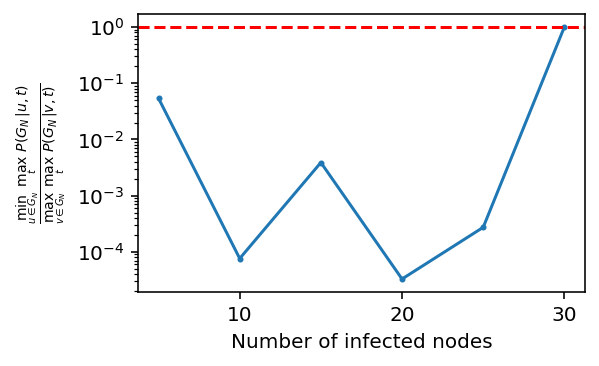

In [43]:
plt.figure(figsize=(4,2.5), dpi=144)

plt.plot(asy_n_list, asy_ratio_list, 'o-', markersize=2)

plt.xlabel('Number of infected nodes')

plt.ylabel(r'$\frac{\min_{u\in G_N} \ \max_{t} \ P(G_N|u, t)}{\max_{v\in G_N} \ \max_{t} \ P(G_N|v, t)}$')

plt.axhline(y = 1, color = 'r', linestyle = '--') 

ax=plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_yscale('log')
# ax.text(-0.4, 0.7, '1', color='r')

In [44]:
asy_time_list = [gr_infection_time_list[i-1] for i in asy_n_list]

Plot $\frac{\min_{u\in G_N} \ \max_{t} \ P(G_N|u, t)}{\max_{v\in G_N} \ \max_{t} \ P(G_N|v, t)}$ vs spreading time.

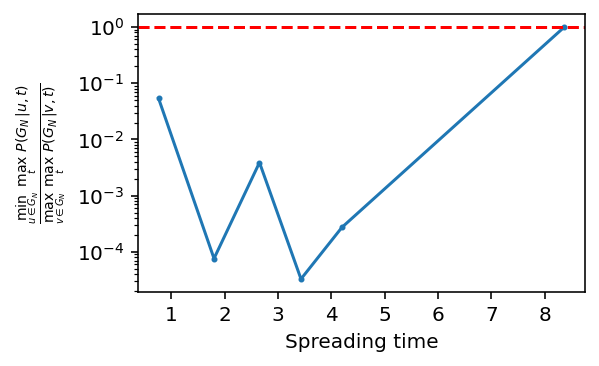

In [45]:
plt.figure(figsize=(4,2.5), dpi=144)

plt.plot(asy_time_list, asy_ratio_list,'o-', markersize=2)

plt.xlabel('Spreading time')

plt.ylabel(r'$\frac{\min_{u\in G_N} \ \max_{t} \ P(G_N|u, t)}{\max_{v\in G_N} \ \max_{t} \ P(G_N|v, t)}$')

plt.axhline(y = 1, color = 'r', linestyle = '--') 

ax=plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_yscale('log')
# ax.text(-0.4, 0.7, '1', color='r')


Run again with refined interval for computing the ratio.

In [46]:
asy_ratio = {}

asy_n_list = list(range(1, n_total+1, 1))

for n_infected in asy_n_list:
    nodes_infected = gr_infection_order_list[0:n_infected]
    
    leaf_infected=set()
    pseudo_leaf_infected=set()
    for i in nodes_infected:
        if len(list(G.subgraph(nodes_infected)[i]))==1:
            leaf_infected.add(i)
        elif len(list(G.subgraph(nodes_infected)[i]))!=len(list(G[i])):
            pseudo_leaf_infected.add(i)

    q={}
    qmax={}
    for u in nodes_infected:
            q[u]=p(G,nodes_infected, leaf_infected, pseudo_leaf_infected, s=u, T=T).subs({T:T})
            qmax[u]=find_max_p_over_t(q[u])[1]
            # print('u', u, qmax[u])            
    # print(qmax[0],qmax[1])

    asy_ratio[n_infected] = min(list(qmax.values())) / max(list(qmax.values()))
    
asy_ratio_list = [asy_ratio[v] for v in asy_n_list]

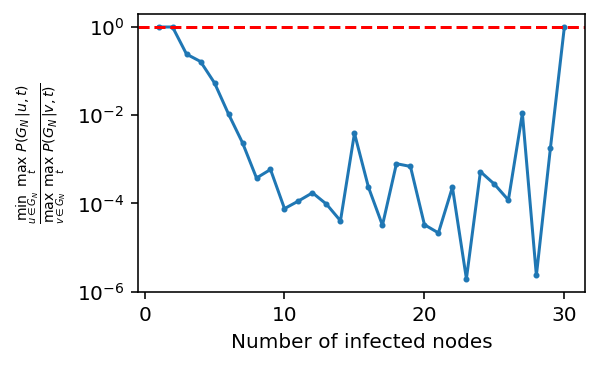

In [47]:
plt.figure(figsize=(4,2.5), dpi=144)

plt.plot(asy_n_list, asy_ratio_list, 'o-', markersize=2)

plt.xlabel('Number of infected nodes')

plt.ylabel(r'$\frac{\min_{u\in G_N} \ \max_{t} \ P(G_N|u, t)}{\max_{v\in G_N} \ \max_{t} \ P(G_N|v, t)}$')

plt.axhline(y = 1, color = 'r', linestyle = '--') 

ax=plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_yscale('log')
ax.set_yticks([10**0,10**-2,10**-4,10**-6])
# ax.text(-0.4, 0.7, '1', color='r')

In [48]:
asy_time_list = [gr_infection_time_list[i-1] for i in asy_n_list]

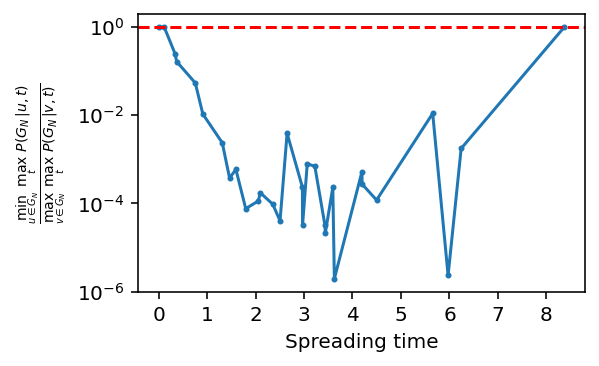

In [49]:
plt.figure(figsize=(4,2.5), dpi=144)

plt.plot(asy_time_list, asy_ratio_list,'o-', markersize=2)

plt.xlabel('Spreading time')

plt.ylabel(r'$\frac{\min_{u\in G_N} \ \max_{t} \ P(G_N|u, t)}{\max_{v\in G_N} \ \max_{t} \ P(G_N|v, t)}$')


plt.axhline(y = 1, color = 'r', linestyle = '--') 

ax=plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_yscale('log')
ax.set_yticks([10**0,10**-2,10**-4,10**-6])
# ax.text(-0.4, 0.7, '1', color='r')


---

Run multiple times to get the average.

In [50]:
def asy_ddt(n_total, asy_n_list):
    G=generate_degree_regular(n_total = n_total)

    gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list = continuous_time_simulation(gnp=G, final_t=np.inf, t_unit=0.001,s_real=0, final_infected_num=None)

    asy_ratio = {}

    for n_infected in asy_n_list:
        nodes_infected = gr_infection_order_list[0:n_infected]
        
        leaf_infected=set()
        pseudo_leaf_infected=set()
        for i in nodes_infected:
            if len(list(G.subgraph(nodes_infected)[i]))==1:
                leaf_infected.add(i)
            elif len(list(G.subgraph(nodes_infected)[i]))!=len(list(G[i])):
                pseudo_leaf_infected.add(i)

        q={}
        qmax={}
        for u in nodes_infected:
                q[u]=p(G,nodes_infected, leaf_infected, pseudo_leaf_infected, s=u, T=T).subs({T:T})
                qmax[u]=find_max_p_over_t(q[u])[1]
                # print('u', u, qmax[u])            
        # print(qmax[0],qmax[1])

        asy_ratio[n_infected] = min(list(qmax.values())) / max(list(qmax.values()))

    asy_ratio_list = [asy_ratio[v] for v in asy_n_list]
    # clean memory
    del G, q, qmax, asy_ratio, gr_infection_order_list
    gc.collect()
    return asy_ratio_list


In [51]:
repeat_runs = 5
collection_asy_ratio_list = []

n_total = 30

asy_n_list = list(range(1, n_total+1, 1))



for iter_run in range(0, repeat_runs):
    iter_run += 1
    iter_asy_ratio_list = asy_ddt(n_total=n_total, asy_n_list=asy_n_list).copy()
    collection_asy_ratio_list.append(iter_asy_ratio_list)
    
    print(datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'), ' finish iteratioin ', iter_run, ' of ', repeat_runs)

231228 13:25:30  finish iteratioin  1  of  5
231228 13:31:48  finish iteratioin  2  of  5
231228 13:38:19  finish iteratioin  3  of  5
231228 13:44:01  finish iteratioin  4  of  5
231228 13:49:44  finish iteratioin  5  of  5


In [52]:
ave_asy_ratio_list = np.mean(collection_asy_ratio_list, axis=0)

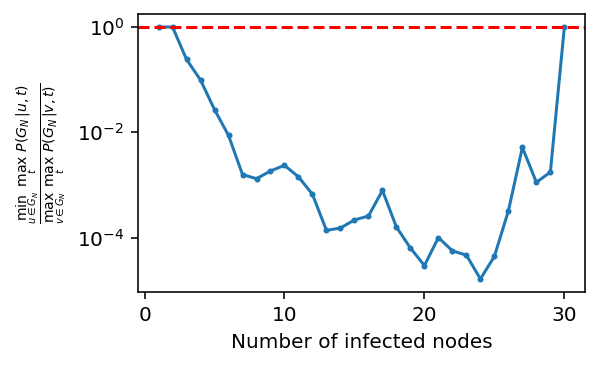

In [53]:
plt.figure(figsize=(4,2.5), dpi=144)

plt.plot(asy_n_list, ave_asy_ratio_list, 'o-', markersize=2)

plt.xlabel('Number of infected nodes')

plt.ylabel(r'$\frac{\min_{u\in G_N} \ \max_{t} \ P(G_N|u, t)}{\max_{v\in G_N} \ \max_{t} \ P(G_N|v, t)}$')

plt.axhline(y = 1, color = 'r', linestyle = '--') 

ax=plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_yscale('log')
# ax.set_yticks([10**0,10**-2,10**-4,10**-6])
# ax.text(-0.4, 0.7, '1', color='r')